In [43]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import re

import xarray as xr
# import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import gsw

In [44]:
## Read in and Process Cruise Track

nav_raw = pd.read_csv("../../data_directory/metadata/hourly_nav_raw.txt", header=None).iloc[:, [0, 2, 3, 4, 5]]
# lon data in degree minutes, need to split the column and convert back to decimal degrees
# need to make lon data negative to reflect W

cruise_track = pd.DataFrame()

cruise_track['lon'] = nav_raw[4].transform(lambda x: x/100).astype('str').str.split('.')
cruise_track['lon_deg'] = pd.to_numeric(cruise_track['lon'].str.get(0))
cruise_track['lon_min'] = pd.to_numeric(cruise_track['lon'].str.get(1).str[:6]).transform(lambda x: (x/10000)/60)
cruise_track['lon'] = cruise_track['lon_deg'] + cruise_track['lon_min']
cruise_track['lon'] = cruise_track['lon'].transform(lambda x: x * -1)

# lat data also needs to be reformatted, but dont need to make it negative
cruise_track['lat'] = nav_raw[2].transform(lambda x: x/100)
cruise_track['lat'] = nav_raw[2].transform(lambda x: x/100).astype('str').str.split('.')
cruise_track['lat_deg'] = pd.to_numeric(cruise_track['lat'].str.get(0))
cruise_track['lat_min'] = pd.to_numeric(cruise_track['lat'].str.get(1).str[:6]).transform(lambda x: (x/10000)/60)
cruise_track['lat'] = cruise_track['lat_deg'] + cruise_track['lat_min']

In [45]:
## Read in Station Data

stations = pd.read_table('../../data_directory/metadata/ctd_stations_SKQ202310S_ToTS.txt')

stations

,StationCast,Section Name,Lat,Lon,Date,Time,Bottom Depth
0,S001C01,BS1,65.6193,-168.150,20230617,744,26
1,S002C01,BS2,65.6483,-168.272,20230617,857,26
2,S003C01,BS3,65.6733,-168.370,20230617,957,51
3,S004C01,BS4,65.6942,-168.463,20230617,1059,54
4,S005C01,BS5,65.7160,-168.559,20230617,1200,52
...,...,...,...,...,...,...,...
299,S296C01,DBO2-9,64.6723,-167.781,20230729,907,35
300,S297C01,DBO2-10,64.6713,-167.464,20230729,1017,28
301,S298C01,DBO2-11,64.6728,-167.150,20230729,1125,29
302,S299C01,DBO2-12,64.6728,-166.835,20230729,1235,25


In [46]:
station_ice = pd.read_csv('../../data_directory/metadata/observed_ice_edge_bridgecam_updated072425.csv')
station_ice

,station,ice_obs
0,1,ow
1,2,ow
2,3,miz
3,4,miz
4,5,miz
...,...,...
295,296,ow
296,297,ow
297,298,ow
298,299,ow


In [47]:
station_lap = pd.read_csv('../../data_directory/metadata/station_metadata_laps.csv')
station_lap

,station,cast,lap,section_name_full,section,sectionStation,latitude,longitude,dist_km
0,1,1,NaN,BS1,BS,1.0,65.6193,-168.150,0.000000
1,2,1,NaN,BS2,BS,2.0,65.6483,-168.272,6.466524
2,3,1,NaN,BS3,BS,3.0,65.6733,-168.370,11.752654
3,4,1,NaN,BS4,BS,4.0,65.6942,-168.463,16.603381
4,5,1,NaN,BS5,BS,5.0,65.7160,-168.559,21.626696
...,...,...,...,...,...,...,...,...,...
299,296,1,NaN,DBO2-9,DBO2,9.0,64.6723,-167.781,104.585148
300,297,1,NaN,DBO2-10,DBO2,10.0,64.6713,-167.464,117.390299
301,298,1,NaN,DBO2-11,DBO2,11.0,64.6728,-167.150,130.396989
302,299,1,NaN,DBO2-12,DBO2,12.0,64.6728,-166.835,143.864039


In [48]:
station_meta = pd.merge(station_lap, station_ice,
                        how='left'
                        ).rename(columns={'ice_obs':'ice_class'}
                                 ).drop(columns=['section_name_full', 'section', 'sectionStation', 'dist_km'])
station_meta

,station,cast,lap,latitude,longitude,ice_class
0,1,1,NaN,65.6193,-168.150,ow
1,2,1,NaN,65.6483,-168.272,ow
2,3,1,NaN,65.6733,-168.370,miz
3,4,1,NaN,65.6942,-168.463,miz
4,5,1,NaN,65.7160,-168.559,miz
...,...,...,...,...,...,...
299,296,1,NaN,64.6723,-167.781,ow
300,297,1,NaN,64.6713,-167.464,ow
301,298,1,NaN,64.6728,-167.150,ow
302,299,1,NaN,64.6728,-166.835,ow


In [49]:
traps = pd.read_csv('../../data_directory/metadata/trap_metadata.csv')[['Deployment', 'Deploy_Station', 'Recover_Station']].drop_duplicates()
traps.rename(columns={'Deployment': 'deployment', 'Deploy_Station': 'deployStation', 'Recover_Station': 'recoverStation'}, inplace=True)

## NOTE: The nominal station number for T026 is 174, but 174 was at the
## same position as station 171 within ~12 hours
## For this reason, we did not conduct a CTD cast at 174, and will use 171 for this figure
traps.loc[traps['deployment'] == 'T026', 'deployStation'] = 171

trap_deploy = pd.merge(traps, station_meta[station_meta['cast'] == 1], 
                       left_on='deployStation', right_on='station', how='left'
                       ).rename(columns={'latitude':'deployLat',
                                         'longitude':'deployLon',
                                         'lap':'deployLap'}
                        ).drop(columns=['station', 'cast'])

trap_recover = pd.merge(traps, station_meta[station_meta['cast'] == 1],
                        left_on='recoverStation', right_on='station', how='left'
                        ).rename(columns={'latitude':'recoverLat',
                                          'longitude':'recoverLon',
                                          'lap':'recoverLap',
                                          'ice_class':'ice_class_recover'}
                        ).drop(columns=['station', 'cast'])

trap_metadata = pd.merge(trap_deploy, trap_recover)
trap_metadata

,deployment,deployStation,recoverStation,deployLap,deployLat,deployLon,ice_class,recoverLap,recoverLat,recoverLon,ice_class_recover
0,T001,15,15,NaN,70.8893,-161.571,ice,NaN,70.8893,-161.571,ice
1,T002,16,24,1.0,70.7053,-165.540,miz,1.0,70.6178,-165.744,miz
2,T003,21,40,1.0,71.2745,-164.577,ice,2.0,71.1925,-164.074,ice
3,T004,26,47,1.0,70.4085,-163.535,ow,2.0,70.3715,-162.807,ow
4,T005,29,52,1.0,70.8067,-163.286,miz,2.0,70.7800,-160.458,ow
5,T006,32,53,1.0,71.1787,-163.023,ice,2.0,71.0797,-161.701,ice
6,T007,38,57,2.0,71.4212,-164.416,ice,2.0,71.2255,-162.912,ice
7,T008,42,78,2.0,71.0638,-165.005,ice,3.0,70.9157,-163.110,ice
8,T009,45,75,2.0,70.7010,-165.522,miz,3.0,70.6748,-163.094,miz
9,T010,48,73,2.0,70.4095,-163.540,ow,3.0,70.5753,-161.548,ow


In [50]:

def append_vars_from_trap_metadata(list_of_varNames, trapInteger, outputDataframe):
    for varName in list_of_varNames:
        outputDataframe[varName] = trap_metadata[trap_metadata['deployment']==str('T'+f'{trapInteger:03}')][varName].values[0]


In [51]:
print('T010 Deployment Lap Must be Hardcoded because data is from different spreadsheet')
print('T010 Deployment Lap =', trap_metadata[trap_metadata['deployment']==str('T010')]['deployLap'].values[0])

T010 Deployment Lap Must be Hardcoded because data is from different spreadsheet
T010 Deployment Lap = 2.0


This next code chunk actually reads in the data

In [52]:
list_of_vars = ['deployLap', 'recoverLap', 'ice_class'] #, 'iceTethered', 'shallowTrapDepth', 'deepTrapDepth', 'ice_class'] #, 'shallowFlux', 'deepFlux']

full_deployments = []
recovery_locations = []
for i in range(1, 30):
    if i == 1:
        print('loop'+ f'{i:02}: T001 was a Test Deployment. Track not included.')
    elif i == 10:
        print('loop'+ f'{i:02}: T010 read in separately beacuse track is from Spotter Beacon')
        t010_beaconLost = pd.read_csv('../../data_directory/array_deployment_gps/T010_full_deployment_beaconLoss.csv')
        t010_spotter = pd.read_csv('../../data_directory/array_deployment_gps/T010_full_deployment_spotter.csv')
        append_vars_from_trap_metadata(list_of_vars, 10, t010_spotter)
    elif i == 21:
        print('loop'+ f'{i:02}: T021 read in separately beacuse trap line was lost before recovery')
        t021_beaconPath = pd.read_csv('../../data_directory/array_deployment_gps/T021_full_deployment_beacon.csv')
        t021_beaconPath.rename(columns={'Asset Name':'assetName',
                                        'Data Date (AKDT)':'dateTimeAKDT',
                                        ' Latitude':'latitude',
                                        ' Longitude':'longitude'}, inplace=True)
        t021_trapLine = pd.read_csv('../../data_directory/array_deployment_gps/T021_full_deployment_trapline.csv')
        t021_trapLine.rename(columns={'Asset Name':'assetName',
                                      'Data Date (AKDT)':'dateTimeAKDT',
                                      ' Latitude':'latitude',
                                      ' Longitude':'longitude'}, inplace=True)
        t021_spotter = pd.read_csv('../../data_directory/array_deployment_gps/T021_full_deployment_spotter.csv')
        t021_spotter['time'] = t021_spotter['Epoch Time'].transform(lambda x: dt.fromtimestamp(x)) # epoch time is in AKDT it seems
        t021_spotter = t021_spotter[t021_spotter['time'] >= dt.strptime('2023-07-13 09:48:00', "%Y-%m-%d %H:%M:%S")] # no time points before deploy
        t021_spotter = t021_spotter[t021_spotter['time'] <= dt.strptime('2023-07-17 09:30:00', "%Y-%m-%d %H:%M:%S")] # no time points after recover
    else:
        try:
            df = pd.read_csv('../../data_directory/array_deployment_gps/T'+ f'{i:03}' +'_full_deployment.csv')
            df['trapNum'] = str('T' + f'{i:03}')
            append_vars_from_trap_metadata(list_of_vars, i, df)
            df.rename(columns={'Asset Name':'assetName',
                                'Data Date (AKDT)':'dateTimeAKDT',
                                ' Latitude':'latitude',
                                ' Longitude':'longitude'}, inplace=True)
            full_deployments.append(df)
                            
            recovery_locations.append(pd.DataFrame({'deployment':['T00'+str(i)],
                                                'final_lat':df['latitude'][0],
                                                'final_lon':df['longitude'][0]}))

        
            print('loop'+ f'{i:02}: ' + df['trapNum'].iloc[0] + ' read in successfully')
        except FileNotFoundError:
            print('loop'+ f'{i:02}: T'+ f'{i:03}_full_deployment.csv not Found' )
        except:
            print('Something Else Went Wrong')

loop01: T001 was a Test Deployment. Track not included.
loop02: T002 read in successfully
loop03: T003 read in successfully
loop04: T004 read in successfully
loop05: T005 read in successfully
loop06: T006 read in successfully
loop07: T007 read in successfully
loop08: T008 read in successfully
loop09: T009 read in successfully
loop10: T010 read in separately beacuse track is from Spotter Beacon
loop11: T011 read in successfully
loop12: T012 read in successfully
loop13: T013 read in successfully
loop14: T014 read in successfully
loop15: T015 read in successfully
loop16: T016 read in successfully
loop17: T017 read in successfully
loop18: T018 read in successfully
loop19: T019 read in successfully
loop20: T020 read in successfully
loop21: T021 read in separately beacuse trap line was lost before recovery
loop22: T022 read in successfully
loop23: T023 read in successfully
loop24: T024 read in successfully
loop25: T025 read in successfully
loop26: T026 read in successfully
loop27: T027 read 

In [53]:
full_deployments[0].columns

Index(['assetName', 'Asset Id', 'dateTimeAKDT', 'latitude', 'longitude',
       ' Speed', ' SATNUM', ' HDOP', ' GPS Accuracy', ' Time To First Fix',
       ' Battery Voltage', ' Temperature', ' Event', ' Report Body', 'trapNum',
       'deployLap', 'recoverLap', 'ice_class'],
      dtype='object')

In [54]:
dist_traveled = []
for deployment in full_deployments:
    print(deployment['trapNum'][0])
    # print(deployment['latitude'].iloc[0])
    # print(deployment['latitude'].iloc[-1])
    distance = gsw.geostrophy.distance([deployment['longitude'].iloc[0], deployment['longitude'].iloc[-1]],
                                       [deployment['latitude'].iloc[0], deployment['latitude'].iloc[-1]])/1000 # in KM
    dist_traveled.append(distance)
    print(distance)
    

T002
[11.84861125]
T003
[19.54280379]
T004
[24.75674791]
T005
[102.69892518]
T006
[48.98082579]
T007
[55.73359614]
T008
[71.37507266]
T009
[89.05565953]
T011
[33.69714723]
T012
[49.59911221]
T013
[82.52213709]
T014
[39.99036735]
T015
[68.9428972]
T016
[49.73271553]
T017
[26.22241556]
T018
[24.19484872]
T019
[35.64485711]
T020
[44.1707671]
T022
[nan]
T023
[16.34075484]
T024
[61.4324864]
T025
[54.36470022]
T026
[23.74141193]
T027
[16.2041971]
T028
[66.33699712]
T029
[36.28973439]


In [55]:
np.nanmean(dist_traveled), np.nanstd(dist_traveled)

(46.13679157488257, 23.886318445538816)

In [56]:
# lon_min, lon_max = -170, -155
# lat_min, lat_max = 65, 75

lon_min, lon_max = -180, 180
lat_min, lat_max = 55, 75


/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: Runti

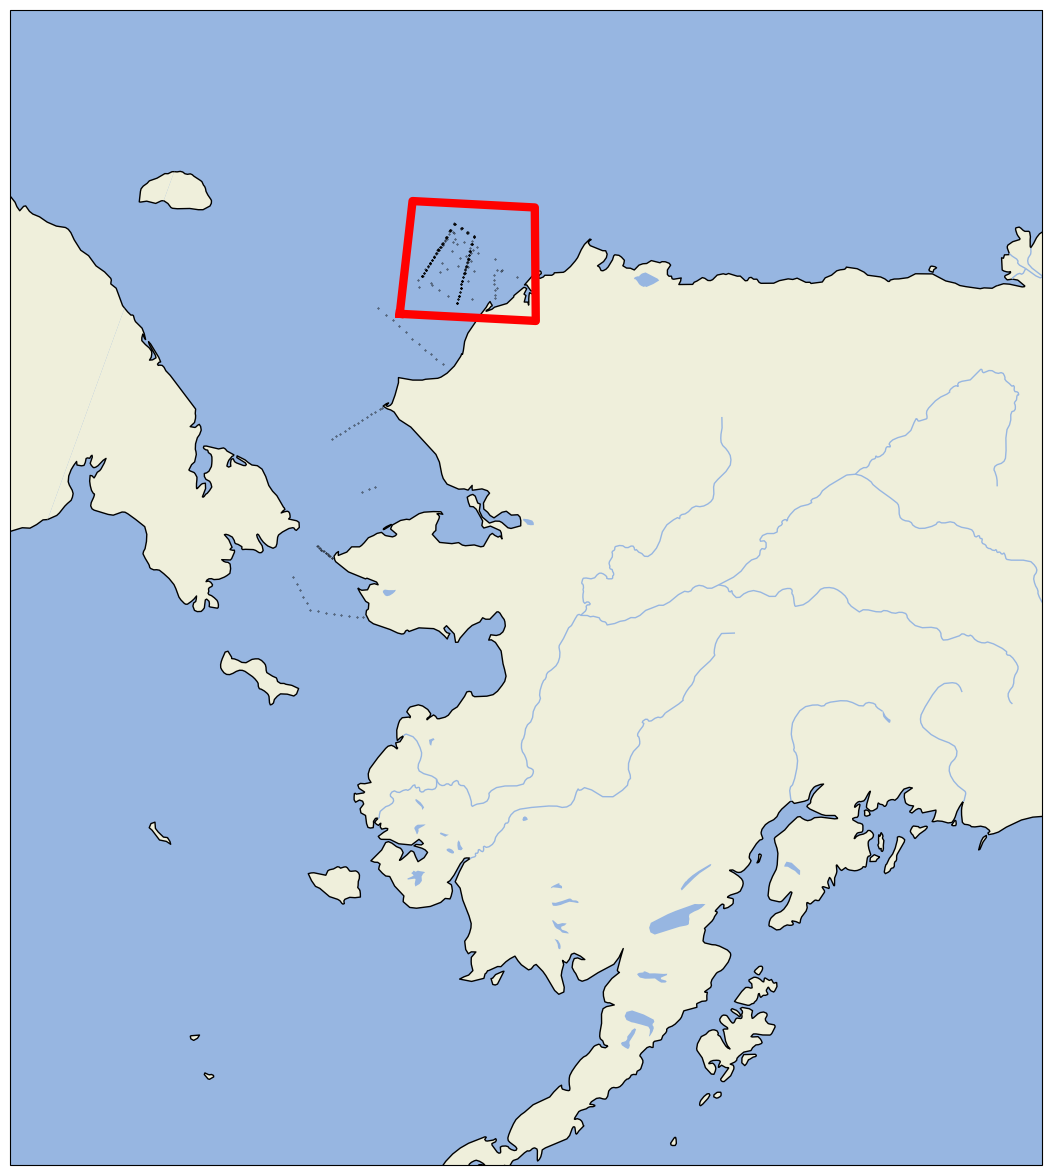

In [57]:
### Context Map

plt.figure(figsize=(15.,15.))

ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=-160))
extent = [-175, -145, 55, 75]
ax.set_extent(extent, ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES) #, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
# ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.25, linestyle='--', draw_labels=True)


# plot region of subplot
ax.plot([-166.5, -159.5, -159.5, -166.5, -166.5], [70, 70, 72, 72, 70],
         color='red', linewidth=6, marker='.',
         transform=ccrs.PlateCarree(), #remove this line to get straight lines
         )

# stations on track
plt.scatter(stations['Lon'], stations['Lat'], color = 'black', s = 0.1, transform = ccrs.PlateCarree())

# cruise track
#plt.plot(cruise_track['lon'], cruise_track['lat'], color = 'gray', linestyle = '--', transform=ccrs.PlateCarree())

plt.show()

In [58]:
def extract_parts(s):
    match = re.match(r'^([A-Za-z]{2,3})(\d+)-(\d+)$', s)
    if match:
        return match.groups()
    return None

stations[['section', 'sectionRepeat', 'sectionStation']] = stations['Section Name'].apply(lambda x: pd.Series(extract_parts(x)))

hr = stations[stations['section']=='HR']
hre = stations[stations['section']=='HRE']

hr_ends = hr[hr['Lat'].isin([np.max(hr['Lat']), np.min(hr['Lat'])])]
# hr_ends = pd.concat([hr[hr['Lon'] == hr['Lon'].min()], hr[hr['Lat'] == hr['Lat'].min()]])
hre_ends = hre[hre['Lat'].isin([np.max(hre['Lat']), np.min(hre['Lat'])])]

/var/folders/8g/k7dpf2yx1v31sdbm639f5tc00000gn/T/ipykernel_11765/3185500522.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stations[['section', 'sectionRepeat', 'sectionStation']] = stations['Section Name'].apply(lambda x: pd.Series(extract_parts(x)))
/var/folders/8g/k7dpf2yx1v31sdbm639f5tc00000gn/T/ipykernel_11765/3185500522.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stations[['section', 'sectionRepeat', 'sectionStation']] = stations['Section Name'].apply(lambda x: pd.Series(extract_parts(x)))
/var/folders/8g/k7dpf2yx1v31sdbm639f5tc00000gn/T/ipykernel_11765/3185500522.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  station

In [59]:
hr_ends

,StationCast,Section Name,Lat,Lon,Date,Time,Bottom Depth,section,sectionRepeat,sectionStation
39,S037C01,HR2-9,71.6752,-164.026,20230627,716,38,HR,2,9
176,S171C01,HR6-1,70.6978,-165.525,20230717,1426,43,HR,6,1


In [60]:
## add in velocity vectors
# import pandas as pd
velocity_data = pd.read_csv('../../data_directory/ADCP_vector_data/interp_uv_0_100_av_jie_mass_balance.dat', delim_whitespace=True, header=None)
# velocity_data.columns = ['lon', 'lat', 'u', 'v']
velocity_data.columns = ['lon', 'lat', 'u', 'v']
velocity_data['u_deg_sec'] = velocity_data['u'] * (1e-5) / (111 * np.cos(np.deg2rad(velocity_data['lat']))) # 1 cm = 10^-5 km, degree = 111 km * cos(latitude)
velocity_data['v_deg_sec'] = velocity_data['v'] * (1e-5) / 111 # 1 cm = 10^-5 km, degree = 111 km
# velocity_data

# Bob velocity data uses slightly different station positions than I did for HR and HRE Lines
# Within 1km margin, but the sligth offset makes the lines look weird
# reset the ends of HR and HRE lines to match velocity data
northernmost_point = velocity_data.loc[velocity_data['lat'].idxmax()]
westernmost_point = velocity_data.loc[velocity_data['lon'].idxmin()]
southernmost_point = velocity_data.loc[velocity_data['lat'].idxmin()]
easternmost_point = velocity_data.loc[velocity_data['lon'].idxmax()]

# HR connects northernmost and westernmost points
hr_ends = pd.concat([northernmost_point.to_frame().T, westernmost_point.to_frame().T], ignore_index=True)

# HRE connects southernmost and easternmost points
hre_ends = pd.concat([southernmost_point.to_frame().T, easternmost_point.to_frame().T], ignore_index=True)

# print("hr_ends (northernmost and westernmost points):")
# print(hr_ends)
# print("\nhre_ends (southernmost and easternmost points):")
# print(hre_ends)

In [61]:
# ice_class_colors = {'ow': "#44C7FF", 'miz': "#FCCE50", 'ice': "#d63a41"}
ice_class_colors = {'ow': "#44C7FF", 'miz': "#FFA500", 'ice': "#d63a41"} # CHANGE MIZ TO ORANGE
t010_color = '#44C7FF'

hr_color = "#2d981d"
# hre_color = "#de9f5c"
hre_color = "#00098C"


In [64]:
text_fontsize = 55 # original: 40
track_endpoint_marker_size = 200 # 100
track_linewidth = 5
transect_linewidth = 7.5 #5

/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


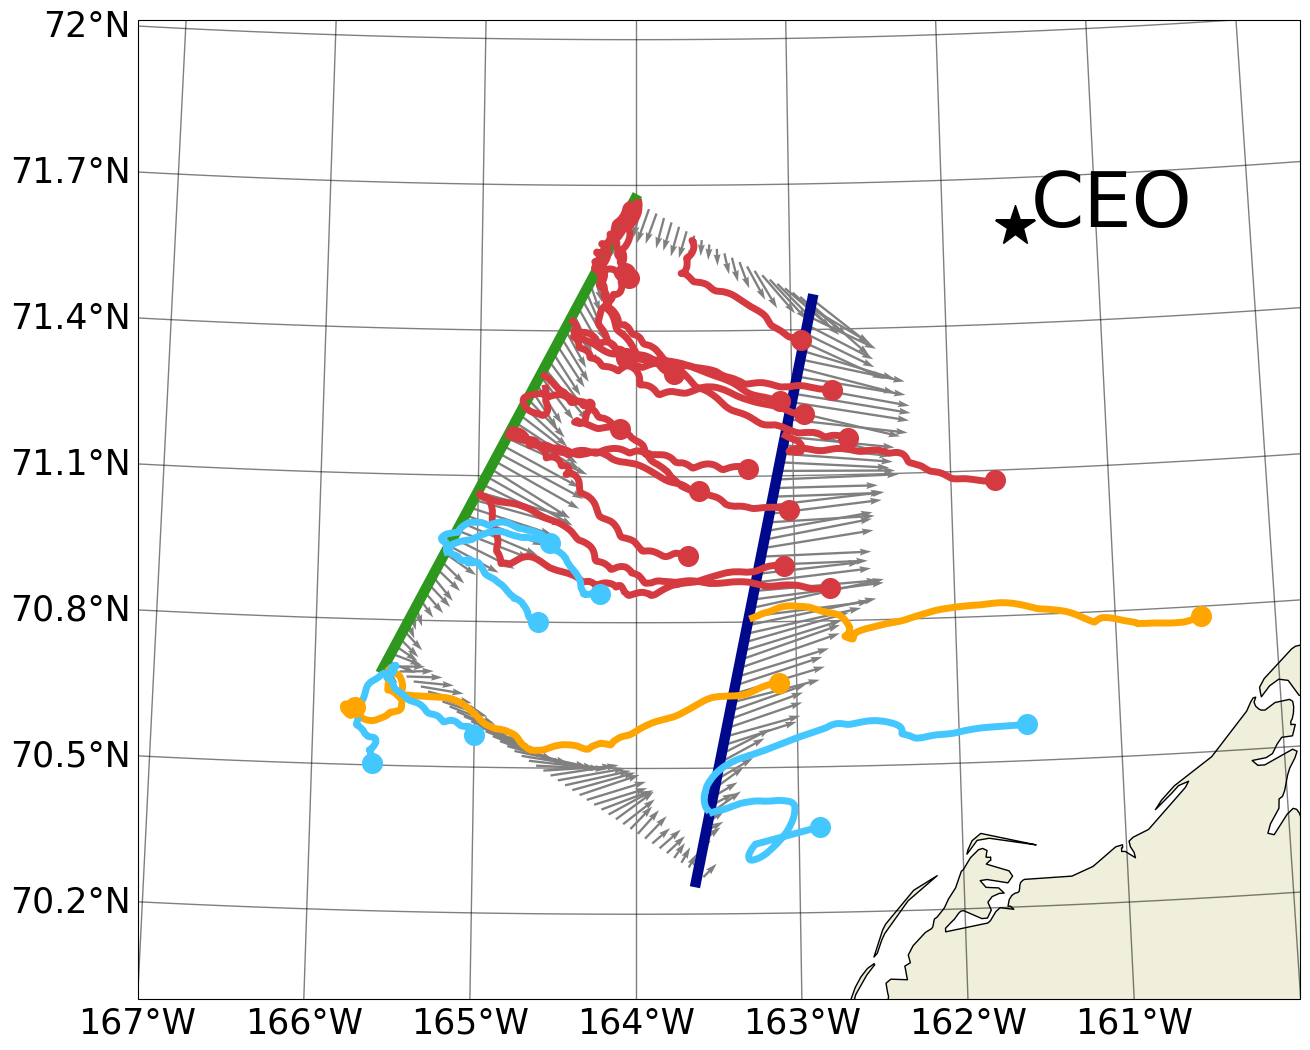

In [70]:
## This actually plots deployments
plt.figure(figsize=(15.,15.), facecolor='none')

plt.rcParams['font.size'] = 25

# ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=-170))
# extent = [-166, -160, 70.25, 71.75]
ax = plt.axes(projection = ccrs.Orthographic(central_latitude=71, central_longitude=-164))
# ax = plt.axes(projection = ccrs.PlateCarree())
extent = [-167, -160, 70, 72]
ax.set_extent(extent, ccrs.PlateCarree())

# gridlines
gl = ax.gridlines(axes = ax, crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, #linestyle='--',
                  draw_labels=True, x_inline=False, y_inline=False,
                  zorder=0)
# gl.xlabel_style = {'rotation': 30}
gl.ylabel_style = {'rotation': 0}
gl.bottom_labels = True
gl.left_labels   = True
gl.top_labels    = False
gl.right_labels  = False


# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

# bathymetry
# contour = ax.contourf(bathy['x'], bathy['y'], bathy['z'], cmap='Blues', 
#                       levels=15, vmin = 0, vmax = 150, transform=ccrs.PlateCarree())
# contour_lines = ax.contour(bathy['x'], bathy['y'], bathy['z'], levels=contour.levels, colors='black',
#                             linewidths=0.5, transform=ccrs.PlateCarree())
# plt.clabel(contour_lines, fmt='%1.1f', inline=True, fontsize=12)

# plot HR and HRE lines
ax.plot(hr_ends['lon'], hr_ends['lat'], color = hr_color, transform=ccrs.PlateCarree(), linewidth = transect_linewidth)
ax.plot(hre_ends['lon'], hre_ends['lat'], color = hre_color, transform=ccrs.PlateCarree(), linewidth = transect_linewidth)

# # plot CN
# plt.plot([hr_ends['Lon'].iloc[0], hre_ends['Lon'].iloc[1]],
#          [hr_ends['Lat'].iloc[0], hre_ends['Lat'].iloc[1]],
#          color = 'gray', transform=ccrs.PlateCarree(),
#          linewidth=3)

# # Plot CS
# plt.plot([hr_ends['Lon'].iloc[1], hre_ends['Lon'].iloc[0]],
#          [hr_ends['Lat'].iloc[1], hre_ends['Lat'].iloc[0]],
#          color = 'gray', transform=ccrs.PlateCarree(),
#          linewidth=3)

# Velocity Vectors
ax.quiver(velocity_data['lon'], velocity_data['lat'],
           velocity_data['u_deg_sec'], velocity_data['v_deg_sec'],
           width=0.002,
           color='gray', alpha = 1, scale=0.00005,
           transform=ccrs.PlateCarree())



# full lines of complete deployments
for i in range(len(full_deployments)):

    ice_class = full_deployments[i]['ice_class'].iloc[0]
    # ice_class = full_deployments[i]['iceTethered'].iloc[0]

    plot = ax.plot(full_deployments[i]['longitude'],
             full_deployments[i]['latitude'],
            #  color = 'darkgreen',
             color = ice_class_colors.get(ice_class, 'gray'),
             linewidth = track_linewidth,
             zorder=4,
            #  alpha = 0.5,
             transform=ccrs.PlateCarree())
    
    ax.scatter(full_deployments[i]['longitude'].iloc[0],
             full_deployments[i]['latitude'].iloc[0],
            #  color = 'darkgreen',
             color = ice_class_colors.get(ice_class, 'gray'),
             s = track_endpoint_marker_size,
             zorder=5,
             transform=ccrs.PlateCarree())

# Plotting in T010 spotter data
ax.plot(t010_spotter['Longitude (deg)'],
         t010_spotter['Latitude (deg)'],
         linewidth = track_linewidth,
         zorder=4,
        #  alpha = 0.5,
        #  color = '#F21A00',
        #  color = '#9932CC',
        color = t010_color,
         transform=ccrs.PlateCarree())
ax.scatter(t010_spotter['Longitude (deg)'].iloc[0],
         t010_spotter['Latitude (deg)'].iloc[0],
         s = track_endpoint_marker_size,
         zorder=5,
         # color = '#F21A00',
         #  color = '#9932CC',
         color = t010_color,
         transform=ccrs.PlateCarree())

## Plot in CEO Observatory at (71º 35.976’ N, 161º 31.621’ W), (71.5996 N, -161.5270 W)
ax.plot(-161.5270, 71.5996, marker='*', color='black', markersize=30, transform=ccrs.PlateCarree())
ax.text(-161.5270 + 0.1, 71.5996, 'CEO', color='black', fontsize=text_fontsize, transform=ccrs.PlateCarree())

# Plot in the NECS Benthic Hotspot Proposed by Grebmeier et al 2015
# NECS (Northeast Chukchi Sea), 70.62°N–72.37°N, 158.46°W–165.46°W.
## Decimal Degrees: [70.62, 72.37] N, [-165.46, -158.46] E
# plt.plot([-165.46, -165.46, -158.46, -158.46, -165.46],
#         [70.62, 72.37, 72.37, 70.62, 70.62],
#         linewidth = 4,
#         color = 'goldenrod',
#         transform=ccrs.PlateCarree())


# cruise track
# plt.plot(cruise_track['lon'], cruise_track['lat'], color = 'gray', alpha = 0.5, linestyle = '--', transform=ccrs.PlateCarree())

plt.savefig('../plot/all_deployments_with_velocityVectors.png', bbox_inches='tight', transparent=True)

plt.show()